In [1]:
from quantML.timeseries import *
import numpy as np
from scipy import linalg as la
from cmath import exp
import pandas as pd
import datetime as dt
from quantML import scrape
from matplotlib import pyplot as plt

In [43]:
# inputs
ticker = 'MMM'
days_train = 365
num_out = 10
stop = dt.datetime.today().date()
start = stop - dt.timedelta(days=days_train)

# scrape
df = scrape.get_prices([ticker], start, stop,)
train = df.close.to_numpy()
t_train = np.arange(train.shape[0])

INFO:quantML.scrape:Scraping MMM - 1 out of 1 tickers


In [44]:
# agument
augment_level = int(df.shape[0] / 2)
X = DMD.augment_matrix(train, augment_level)
time = np.arange(X.shape[1])
num_svs = np.arange(min(X.shape)-1)+1

In [70]:
error = []
all_res = []
for num_svd in num_svs:
    
    # decomp
    dmd_res = DMD.decomp(X, time, num_svd=num_svd, verbose=False, svd_cut=True, rank_cut=False)
    error.append(dmd_res.error)
    t_pred_a = np.arange(num_out) + 1 + max(time)
    t_pred = np.arange(num_out) + 1 + max(t_train)

    # prediction
    pred = DMD.predict_vec(dmd_res, t_pred_a)
    pred_time_mat = np.zeros(pred.shape)
    for row in range(pred_time_mat.shape[0]):
        for col in range(pred_time_mat.shape[1]):
            pred_time_mat[row, col] = row + col + X.shape[1] + 1

    # result dataframe
    res = pd.DataFrame()
    res['pred'] = pred.flatten()
    res['time'] = pred_time_mat.flatten()
    res = res.groupby('time').mean().reset_index()
    res = res[res.time > t_train.max()+1]
    res['svd'] = num_svd
    all_res.append(res)

# correct for error
sv_ind = np.argmin(error)
sv_allowed = num_svs[0:sv_ind+1]
all_res = pd.concat(all_res)
all_res = all_res[all_res.svd.isin(sv_allowed)]
helps = all_res.copy()

# fix result DF
summary = all_res.groupby(['time']).agg({'pred': [np.mean, np.std, np.min, np.max]})
summary.columns = ['mean', 'std', 'min', 'max']
summary['pred'] = all_res[all_res.svd == all_res.svd.max()].pred.to_numpy()
summary = summary.reset_index()

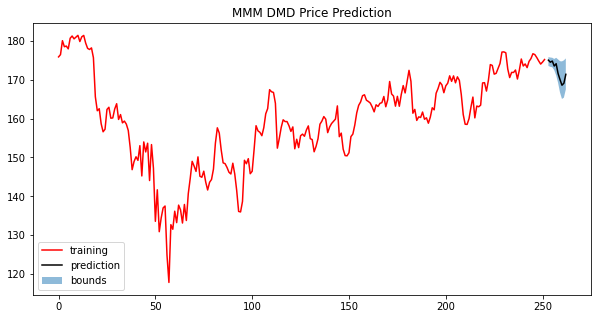

In [71]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot()
ax.plot(t_train, train, 'r', label = 'training')
ax.plot(summary['time'], summary['pred'], 'k', label = 'prediction')
ax.fill_between(summary['time'], summary['mean'] + summary['std']*2, summary['mean'] - summary['std']*2, alpha=0.5, label='bounds')
ax.set_title(f'{ticker} DMD Price Prediction')
ax.legend()
plt.show()